In [24]:
import pandas as pd
import polars as pl
import xgboost as xgb 
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.pipeline import Pipeline
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb
import plotly.express as px

In [25]:
dfEmpresas = pd.read_csv("../ExploracaoDados/ExtracoesBanco/DadosEmpresasParaModeloV4.csv", sep=";", decimal=",").drop(["MesesAteSituacaoAtual", "IdadeCadastroEmMeses", "MEIATIVO", "SIMPLESATIVO", "DATA SITUAÇÃO CADASTRAL", "SITUAÇÃO CADASTRAL", "CNPJ BÁSICO", "DATA DE INÍCIO ATIVIDADE", "PORTE DA EMPRESA"], axis=1)
dfEmpresas = dfEmpresas.fillna(0)
dfEmpresas["ClassicacaoDeViabilidada"] = dfEmpresas["ClassicacaoDeViabilidada"].replace(2, 0)
dfEmpresas

,CNAE FISCAL PRINCIPAL,CEP,UF,NATUREZA JURÍDICA,QUALIFICAÇÃO DO RESPONSÁVEL,FLAGSIMPLES,FLAGMEI,CÓDIGO_DO_MUNICÍPIO_IBGE,ANOABERTURA,PIB_2016,...,De_70_a_74_anos,De_80_anos_ou_mais,De_75_a_79_anos,Pib_2016_Corrigido,PIB_Delta_Corr,PIB_Cresc_Corr,POP_22,EmpresasSimilaresAbertas,EmpresasSimilaresFechadas,ClassicacaoDeViabilidada
0,159802,3503010,SP,2135,50,S,S,3550308.0,2010,0.000000e+00,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0
1,161003,3959020,SP,2135,50,S,S,3550308.0,2022,0.000000e+00,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0
2,724301,4077020,SP,2062,49,S,N,3550308.0,2015,0.000000e+00,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.0,0.0,0
3,1091101,2967020,SP,2135,50,S,S,3550308.0,2011,0.000000e+00,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,1
4,1091101,3981060,SP,2062,49,S,N,3550308.0,2019,0.000000e+00,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746835,9700500,99704698,RS,2135,50,S,S,4307005.0,2019,3.793773e+09,...,36410.0,32360.0,24090.0,5.167498e+13,6.123145e+12,1.184934e+16,1073680.0,0.0,0.0,0
746836,9700500,98995000,RS,2135,50,S,S,4315107.0,2022,1.474034e+08,...,4260.0,3570.0,2960.0,2.007782e+12,-6.703456e+15,-3.338736e+16,101440.0,11.0,7.0,0
746837,9700500,95965000,RS,2135,50,S,S,4315453.0,2023,4.706275e+06,...,1250.0,1520.0,980.0,6.410417e+10,1.573815e+16,2.455089e+15,20680.0,2.0,0.0,1
746838,9700500,98760000,RS,2135,50,S,S,4305405.0,2024,1.855251e+08,...,1670.0,1360.0,1240.0,2.527037e+12,1.265951e+16,5.009628e+15,36840.0,0.0,0.0,1


In [26]:
numMortalidade = (dfEmpresas["ClassicacaoDeViabilidada"] == 1).sum()
print(numMortalidade)

193318


In [27]:
numSemMortalidade = (dfEmpresas["ClassicacaoDeViabilidada"] == 0).sum()
print(numSemMortalidade)

553522


In [28]:
categorias = ["Empresas Viáveis", "Empresas com Mortalidade Precocce"]
valores = [numSemMortalidade, numMortalidade]

fig = px.bar(
    x=categorias, 
    y=valores, 
    title='Número de Exemplos de Cada Classe na Base de Treinamento',
    labels={'x': 'Classes', 'y': 'Número de Exemplos'}
)

fig.update_traces(
    textposition='outside',
    marker_line_color='black',
    marker_line_width=1.5,
    width=0.5
)

fig.update_layout(
    title_x=0.5,
    font=dict(size=16),
    xaxis_title='Categorias',
    yaxis_title='Valores',
    plot_bgcolor='white',
    bargap=0.3,
    height=500,
    width=800
)

fig.show()

In [29]:
x = (dfEmpresas["ClassicacaoDeViabilidada"] == 2).sum()
print(x)

0


In [30]:
dfEmpresas["ANOABERTURA"].unique()

array([2010, 2022, 2015, 2011, 2019, 2012, 2013, 2014, 2018, 2024, 2017,
       2016, 2023, 2008, 2009, 2025, 2020])

In [31]:
dfEmpresasTrain = dfEmpresas[dfEmpresas["ANOABERTURA"] < 2016]
dfEmpresasTest = dfEmpresas[dfEmpresas["ANOABERTURA"] >= 2016] #redividir
dfEmpresasTest = dfEmpresasTest[dfEmpresasTest["ANOABERTURA"] < 2018]
dfEmpresasTest22 = dfEmpresas[dfEmpresas["ANOABERTURA"] == 2022]


In [32]:
dfEmpresas

,CNAE FISCAL PRINCIPAL,CEP,UF,NATUREZA JURÍDICA,QUALIFICAÇÃO DO RESPONSÁVEL,FLAGSIMPLES,FLAGMEI,CÓDIGO_DO_MUNICÍPIO_IBGE,ANOABERTURA,PIB_2016,...,De_70_a_74_anos,De_80_anos_ou_mais,De_75_a_79_anos,Pib_2016_Corrigido,PIB_Delta_Corr,PIB_Cresc_Corr,POP_22,EmpresasSimilaresAbertas,EmpresasSimilaresFechadas,ClassicacaoDeViabilidada
0,159802,3503010,SP,2135,50,S,S,3550308.0,2010,0.000000e+00,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0
1,161003,3959020,SP,2135,50,S,S,3550308.0,2022,0.000000e+00,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0
2,724301,4077020,SP,2062,49,S,N,3550308.0,2015,0.000000e+00,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.0,0.0,0
3,1091101,2967020,SP,2135,50,S,S,3550308.0,2011,0.000000e+00,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,1
4,1091101,3981060,SP,2062,49,S,N,3550308.0,2019,0.000000e+00,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746835,9700500,99704698,RS,2135,50,S,S,4307005.0,2019,3.793773e+09,...,36410.0,32360.0,24090.0,5.167498e+13,6.123145e+12,1.184934e+16,1073680.0,0.0,0.0,0
746836,9700500,98995000,RS,2135,50,S,S,4315107.0,2022,1.474034e+08,...,4260.0,3570.0,2960.0,2.007782e+12,-6.703456e+15,-3.338736e+16,101440.0,11.0,7.0,0
746837,9700500,95965000,RS,2135,50,S,S,4315453.0,2023,4.706275e+06,...,1250.0,1520.0,980.0,6.410417e+10,1.573815e+16,2.455089e+15,20680.0,2.0,0.0,1
746838,9700500,98760000,RS,2135,50,S,S,4305405.0,2024,1.855251e+08,...,1670.0,1360.0,1240.0,2.527037e+12,1.265951e+16,5.009628e+15,36840.0,0.0,0.0,1


In [33]:
dfEmpresasTrain = dfEmpresasTrain.drop("ANOABERTURA", axis=1)
dfEmpresasTest = dfEmpresasTest.drop("ANOABERTURA", axis=1)
dfEmpresasTest22 = dfEmpresasTest22.drop("ANOABERTURA", axis=1)
#dfEmpresasTest15 = dfEmpresasTest15.drop("ANOABERTURA", axis=1)

In [34]:
XTrain = dfEmpresasTrain.drop("ClassicacaoDeViabilidada", axis=1)
YTrain = dfEmpresasTrain["ClassicacaoDeViabilidada"]

XTest22 = dfEmpresasTest22.drop("ClassicacaoDeViabilidada", axis=1)
YTest22 = dfEmpresasTest22["ClassicacaoDeViabilidada"]


In [35]:
x = (YTrain == 1).sum()
print(x)

41092


In [36]:
x = (YTrain == 0).sum()
print(x)

278598


In [37]:
undersample = RandomUnderSampler(sampling_strategy='majority')
XTrain, YTrain = undersample.fit_resample(XTrain, YTrain)

In [38]:
transformers = ColumnTransformer(
    transformers=[
        ("UF", OrdinalEncoder(), ["UF"]),
        ("FLAGSIMPLES", OrdinalEncoder(), ["FLAGSIMPLES"]),
        ("FLAGMEI", OrdinalEncoder(), ["FLAGMEI"])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [39]:
def objective(trial):
    model_name = trial.suggest_categorical('model', ['xgboost', 'lightgbm', 'catboost', 'random_forest', 'decision_tree'])

    if model_name == 'xgboost':
        model = xgb.XGBClassifier(
            learning_rate=trial.suggest_float('xgb_lr', 0.001, 0.3, log=True),
            n_estimators=trial.suggest_int('xgb_n_estimators', 100, 1000), 
            max_depth=trial.suggest_int('xgb_max_depth', 3, 10),
            subsample=trial.suggest_float('xgb_subsample', 0.6, 1.0),
            colsample_bytree=trial.suggest_float('xgb_colsample_bytree', 0.6, 1.0),
            min_child_weight=trial.suggest_int('xgb_min_child_weight', 1, 7),
            gamma=trial.suggest_float('xgb_gamma', 0, 0.5),
            random_state=42,
            n_jobs=-1
        )

    elif model_name == 'lightgbm':
        model = lgb.LGBMClassifier(
            learning_rate=trial.suggest_float('lgb_lr', 0.001, 0.3, log=True),
            n_estimators=trial.suggest_int('lgb_n_estimators', 100, 1000),
            num_leaves=trial.suggest_int('lgb_num_leaves', 20, 150),
            max_depth=trial.suggest_int('lgb_max_depth', 3, 12),
            subsample=trial.suggest_float('lgb_subsample', 0.6, 1.0),
            colsample_bytree=trial.suggest_float('lgb_colsample_bytree', 0.6, 1.0),
            min_child_samples=trial.suggest_int('lgb_min_child_samples', 5, 100),
            reg_alpha=trial.suggest_float('lgb_reg_alpha', 0, 1),
            reg_lambda=trial.suggest_float('lgb_reg_lambda', 0, 1),
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )

    elif model_name == 'catboost':
        model = CatBoostClassifier(
            learning_rate=trial.suggest_float('cat_lr', 0.001, 0.3, log=True),
            iterations=trial.suggest_int('cat_iterations', 100, 1000),
            depth=trial.suggest_int('cat_depth', 4, 10),
            l2_leaf_reg=trial.suggest_float('cat_l2', 1, 10),
            border_count=trial.suggest_int('cat_border_count', 32, 255),
            random_state=42,
            verbose=0,
            thread_count=-1
        )

    elif model_name == 'random_forest':
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int('rf_n_estimators', 100, 500),
            max_depth=trial.suggest_int('rf_max_depth', 5, 30), 
            min_samples_split=trial.suggest_int('rf_min_samples_split', 2, 20),
            min_samples_leaf=trial.suggest_int('rf_min_samples_leaf', 1, 10),
            max_features=trial.suggest_categorical('rf_max_features', ['sqrt', 'log2']),
            random_state=42,
            n_jobs=-1
        )

    else:
        model = DecisionTreeClassifier(
            max_depth=trial.suggest_int('dt_max_depth', 3, 3000),
            min_samples_split=trial.suggest_int('dt_min_samples_split', 2, 2000),
            min_samples_leaf=trial.suggest_int('dt_min_samples_leaf', 1, 10),
            max_features=trial.suggest_categorical('dt_max_features', ['sqrt', 'log2', None]),
            criterion=trial.suggest_categorical('dt_criterion', ['gini', 'entropy']),
            splitter=trial.suggest_categorical('dt_splitter', ['best', 'random']),
            min_impurity_decrease=trial.suggest_float('dt_min_impurity_decrease', 0.0, 0.2),
            random_state=42
        )

    pipeline = Pipeline([
        ('preprocessor', transformers),
        ('classifier', model)
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, XTrain, YTrain, cv=cv, scoring='f1', n_jobs=-1)

    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

# Resultados
print("Melhor valor (f1):", study.best_value)
print("Melhores parâmetros:", study.best_params)


[I 2025-11-09 18:32:27,613] A new study created in memory with name: no-name-7bbc7494-d673-42b5-bda2-17fc7588a472
Best trial: 0. Best value: 0.652446:   1%|          | 1/100 [00:15<25:37, 15.53s/it]

[I 2025-11-09 18:32:43,140] Trial 0 finished with value: 0.6524462988880793 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.2021384764084699, 'lgb_n_estimators': 419, 'lgb_num_leaves': 95, 'lgb_max_depth': 3, 'lgb_subsample': 0.7839694497985145, 'lgb_colsample_bytree': 0.7936006720429117, 'lgb_min_child_samples': 70, 'lgb_reg_alpha': 0.11672817289917858, 'lgb_reg_lambda': 0.6182687631082445}. Best is trial 0 with value: 0.6524462988880793.


Best trial: 1. Best value: 0.662148:   2%|▏         | 2/100 [00:21<15:53,  9.73s/it]

[I 2025-11-09 18:32:48,807] Trial 1 finished with value: 0.6621483598323261 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.03670626869757772, 'lgb_n_estimators': 301, 'lgb_num_leaves': 50, 'lgb_max_depth': 4, 'lgb_subsample': 0.9133988223971936, 'lgb_colsample_bytree': 0.687758366971687, 'lgb_min_child_samples': 45, 'lgb_reg_alpha': 0.1499995831850266, 'lgb_reg_lambda': 0.37750852301985693}. Best is trial 1 with value: 0.6621483598323261.


Best trial: 1. Best value: 0.662148:   3%|▎         | 3/100 [00:34<18:41, 11.56s/it]

[I 2025-11-09 18:33:02,550] Trial 2 finished with value: 0.6607552246839574 and parameters: {'model': 'xgboost', 'xgb_lr': 0.013127284173132121, 'xgb_n_estimators': 851, 'xgb_max_depth': 4, 'xgb_subsample': 0.7649503116513727, 'xgb_colsample_bytree': 0.8257144308648882, 'xgb_min_child_weight': 2, 'xgb_gamma': 0.1266915127300302}. Best is trial 1 with value: 0.6621483598323261.


Best trial: 3. Best value: 0.68326:   4%|▍         | 4/100 [00:41<15:15,  9.54s/it] 

[I 2025-11-09 18:33:08,989] Trial 3 finished with value: 0.683260158539729 and parameters: {'model': 'catboost', 'cat_lr': 0.00269897476916715, 'cat_iterations': 139, 'cat_depth': 4, 'cat_l2': 3.8948980550223724, 'cat_border_count': 79}. Best is trial 3 with value: 0.683260158539729.


Best trial: 3. Best value: 0.68326:   5%|▌         | 5/100 [00:42<10:08,  6.40s/it]

[I 2025-11-09 18:33:09,825] Trial 4 finished with value: 0.266655850740215 and parameters: {'model': 'decision_tree', 'dt_max_depth': 1061, 'dt_min_samples_split': 1139, 'dt_min_samples_leaf': 1, 'dt_max_features': None, 'dt_criterion': 'gini', 'dt_splitter': 'best', 'dt_min_impurity_decrease': 0.043375929488619236}. Best is trial 3 with value: 0.683260158539729.


Best trial: 3. Best value: 0.68326:   6%|▌         | 6/100 [00:49<10:37,  6.78s/it]

[I 2025-11-09 18:33:17,336] Trial 5 finished with value: 0.6633581476766752 and parameters: {'model': 'xgboost', 'xgb_lr': 0.0017227982881411034, 'xgb_n_estimators': 122, 'xgb_max_depth': 9, 'xgb_subsample': 0.7378383555322202, 'xgb_colsample_bytree': 0.8650921689563418, 'xgb_min_child_weight': 6, 'xgb_gamma': 0.09918276074697274}. Best is trial 3 with value: 0.683260158539729.


Best trial: 3. Best value: 0.68326:   7%|▋         | 7/100 [00:50<07:27,  4.81s/it]

[I 2025-11-09 18:33:18,109] Trial 6 finished with value: 0.266655850740215 and parameters: {'model': 'decision_tree', 'dt_max_depth': 1002, 'dt_min_samples_split': 1677, 'dt_min_samples_leaf': 10, 'dt_max_features': 'log2', 'dt_criterion': 'gini', 'dt_splitter': 'best', 'dt_min_impurity_decrease': 0.08597292927978782}. Best is trial 3 with value: 0.683260158539729.


Best trial: 3. Best value: 0.68326:   8%|▊         | 8/100 [00:51<05:24,  3.53s/it]

[I 2025-11-09 18:33:18,880] Trial 7 finished with value: 0.266655850740215 and parameters: {'model': 'decision_tree', 'dt_max_depth': 662, 'dt_min_samples_split': 689, 'dt_min_samples_leaf': 3, 'dt_max_features': None, 'dt_criterion': 'entropy', 'dt_splitter': 'random', 'dt_min_impurity_decrease': 0.09648769154675568}. Best is trial 3 with value: 0.683260158539729.


Best trial: 8. Best value: 0.683614:   9%|▉         | 9/100 [00:54<05:23,  3.55s/it]

[I 2025-11-09 18:33:22,494] Trial 8 finished with value: 0.6836137047874538 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0030834635975029354, 'lgb_n_estimators': 162, 'lgb_num_leaves': 49, 'lgb_max_depth': 4, 'lgb_subsample': 0.6992667493921048, 'lgb_colsample_bytree': 0.9039852945938657, 'lgb_min_child_samples': 39, 'lgb_reg_alpha': 0.32996198644470043, 'lgb_reg_lambda': 0.905484551041504}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  10%|█         | 10/100 [01:01<06:41,  4.46s/it]

[I 2025-11-09 18:33:28,977] Trial 9 finished with value: 0.6499401867340577 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.07567373792085152, 'lgb_n_estimators': 535, 'lgb_num_leaves': 24, 'lgb_max_depth': 8, 'lgb_subsample': 0.9231391900017191, 'lgb_colsample_bytree': 0.8549245369323254, 'lgb_min_child_samples': 88, 'lgb_reg_alpha': 0.24319050974732936, 'lgb_reg_lambda': 0.5717763987636141}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  11%|█         | 11/100 [01:38<21:37, 14.58s/it]

[I 2025-11-09 18:34:06,503] Trial 10 finished with value: 0.6294795480720733 and parameters: {'model': 'random_forest', 'rf_n_estimators': 295, 'rf_max_depth': 30, 'rf_min_samples_split': 15, 'rf_min_samples_leaf': 3, 'rf_max_features': 'sqrt'}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  12%|█▏        | 12/100 [01:43<16:47, 11.45s/it]

[I 2025-11-09 18:34:10,789] Trial 11 finished with value: 0.6832740251142209 and parameters: {'model': 'catboost', 'cat_lr': 0.002168725837511519, 'cat_iterations': 119, 'cat_depth': 4, 'cat_l2': 3.682837801811735, 'cat_border_count': 74}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  13%|█▎        | 13/100 [02:11<23:52, 16.47s/it]

[I 2025-11-09 18:34:38,817] Trial 12 finished with value: 0.6350550298124097 and parameters: {'model': 'catboost', 'cat_lr': 0.1751180349839084, 'cat_iterations': 879, 'cat_depth': 6, 'cat_l2': 1.2379440230887964, 'cat_border_count': 35}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  14%|█▍        | 14/100 [02:23<21:57, 15.32s/it]

[I 2025-11-09 18:34:51,493] Trial 13 finished with value: 0.6819445902742698 and parameters: {'model': 'catboost', 'cat_lr': 0.0011761014693612726, 'cat_iterations': 104, 'cat_depth': 9, 'cat_l2': 9.785325814607921, 'cat_border_count': 223}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  15%|█▌        | 15/100 [02:39<21:44, 15.35s/it]

[I 2025-11-09 18:35:06,903] Trial 14 finished with value: 0.6822434142626062 and parameters: {'model': 'random_forest', 'rf_n_estimators': 478, 'rf_max_depth': 5, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 10, 'rf_max_features': 'log2'}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  16%|█▌        | 16/100 [02:52<20:47, 14.86s/it]

[I 2025-11-09 18:35:20,609] Trial 15 finished with value: 0.6682642197847758 and parameters: {'model': 'catboost', 'cat_lr': 0.013174981224110297, 'cat_iterations': 529, 'cat_depth': 4, 'cat_l2': 5.850909569333159, 'cat_border_count': 126}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  17%|█▋        | 17/100 [03:39<33:32, 24.25s/it]

[I 2025-11-09 18:36:06,697] Trial 16 finished with value: 0.6571815413658676 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.00129871027593946, 'lgb_n_estimators': 940, 'lgb_num_leaves': 146, 'lgb_max_depth': 11, 'lgb_subsample': 0.6368309786555855, 'lgb_colsample_bytree': 0.9883866387393716, 'lgb_min_child_samples': 9, 'lgb_reg_alpha': 0.8095677981997024, 'lgb_reg_lambda': 0.9284467406264063}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  18%|█▊        | 18/100 [04:02<32:43, 23.94s/it]

[I 2025-11-09 18:36:29,921] Trial 17 finished with value: 0.6709356190380552 and parameters: {'model': 'catboost', 'cat_lr': 0.00842607728439737, 'cat_iterations': 451, 'cat_depth': 7, 'cat_l2': 4.703134211785969, 'cat_border_count': 171}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  19%|█▉        | 19/100 [04:05<23:48, 17.64s/it]

[I 2025-11-09 18:36:32,881] Trial 18 finished with value: 0.6594424697688465 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.003435279993798906, 'lgb_n_estimators': 103, 'lgb_num_leaves': 79, 'lgb_max_depth': 6, 'lgb_subsample': 0.6503140239656998, 'lgb_colsample_bytree': 0.9781878426360874, 'lgb_min_child_samples': 33, 'lgb_reg_alpha': 0.5879895171958336, 'lgb_reg_lambda': 0.041307036485329074}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  20%|██        | 20/100 [04:16<21:07, 15.85s/it]

[I 2025-11-09 18:36:44,559] Trial 19 finished with value: 0.6547441336901458 and parameters: {'model': 'random_forest', 'rf_n_estimators': 108, 'rf_max_depth': 16, 'rf_min_samples_split': 20, 'rf_min_samples_leaf': 8, 'rf_max_features': 'sqrt'}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  21%|██        | 21/100 [04:21<16:30, 12.53s/it]

[I 2025-11-09 18:36:49,365] Trial 20 finished with value: 0.6512385404030591 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2545119659328893, 'xgb_n_estimators': 335, 'xgb_max_depth': 3, 'xgb_subsample': 0.9768009253132718, 'xgb_colsample_bytree': 0.601504279381232, 'xgb_min_child_weight': 1, 'xgb_gamma': 0.46777793825917}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  22%|██▏       | 22/100 [04:25<12:51,  9.89s/it]

[I 2025-11-09 18:36:53,082] Trial 21 finished with value: 0.683266635698083 and parameters: {'model': 'catboost', 'cat_lr': 0.0010514817200364358, 'cat_iterations': 104, 'cat_depth': 4, 'cat_l2': 3.765624029113727, 'cat_border_count': 56}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  23%|██▎       | 23/100 [04:35<12:33,  9.78s/it]

[I 2025-11-09 18:37:02,618] Trial 22 finished with value: 0.6833368933428842 and parameters: {'model': 'catboost', 'cat_lr': 0.0011031365485847818, 'cat_iterations': 269, 'cat_depth': 5, 'cat_l2': 2.534232163245938, 'cat_border_count': 34}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  24%|██▍       | 24/100 [04:51<14:51, 11.72s/it]

[I 2025-11-09 18:37:18,873] Trial 23 finished with value: 0.6799798083269788 and parameters: {'model': 'catboost', 'cat_lr': 0.004072582492430704, 'cat_iterations': 371, 'cat_depth': 6, 'cat_l2': 1.5552086110702594, 'cat_border_count': 101}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  25%|██▌       | 25/100 [05:02<14:22, 11.50s/it]

[I 2025-11-09 18:37:29,840] Trial 24 finished with value: 0.6586885091634544 and parameters: {'model': 'catboost', 'cat_lr': 0.06710814444003199, 'cat_iterations': 306, 'cat_depth': 5, 'cat_l2': 2.722932976482962, 'cat_border_count': 32}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  26%|██▌       | 26/100 [05:30<20:30, 16.63s/it]

[I 2025-11-09 18:37:58,448] Trial 25 finished with value: 0.6610736904478313 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.006521012921739775, 'lgb_n_estimators': 899, 'lgb_num_leaves': 69, 'lgb_max_depth': 7, 'lgb_subsample': 0.7607805361178193, 'lgb_colsample_bytree': 0.8595953685129484, 'lgb_min_child_samples': 18, 'lgb_reg_alpha': 0.4634491128772565, 'lgb_reg_lambda': 0.9815652221732429}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  27%|██▋       | 27/100 [07:15<52:25, 43.08s/it]

[I 2025-11-09 18:39:43,246] Trial 26 finished with value: 0.6694264517848495 and parameters: {'model': 'catboost', 'cat_lr': 0.0032809808669778287, 'cat_iterations': 733, 'cat_depth': 10, 'cat_l2': 6.445325636513791, 'cat_border_count': 87}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  28%|██▊       | 28/100 [07:25<39:35, 32.99s/it]

[I 2025-11-09 18:39:52,697] Trial 27 finished with value: 0.6661605577571608 and parameters: {'model': 'catboost', 'cat_lr': 0.02890427690931621, 'cat_iterations': 272, 'cat_depth': 5, 'cat_l2': 2.7828386596199457, 'cat_border_count': 159}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  29%|██▉       | 29/100 [07:28<28:36, 24.18s/it]

[I 2025-11-09 18:39:56,313] Trial 28 finished with value: 0.6715597527871185 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.010361901099300845, 'lgb_n_estimators': 120, 'lgb_num_leaves': 24, 'lgb_max_depth': 10, 'lgb_subsample': 0.7030763507935615, 'lgb_colsample_bytree': 0.6019311731272293, 'lgb_min_child_samples': 61, 'lgb_reg_alpha': 0.9955220275014999, 'lgb_reg_lambda': 0.785602191444785}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  30%|███       | 30/100 [07:39<23:41, 20.31s/it]

[I 2025-11-09 18:40:07,608] Trial 29 finished with value: 0.6748348947964158 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0010748881433444058, 'lgb_n_estimators': 684, 'lgb_num_leaves': 115, 'lgb_max_depth': 5, 'lgb_subsample': 0.8601224113716658, 'lgb_colsample_bytree': 0.8993391188637936, 'lgb_min_child_samples': 35, 'lgb_reg_alpha': 0.45496933239726456, 'lgb_reg_lambda': 0.31066005740123515}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  31%|███       | 31/100 [07:53<21:08, 18.39s/it]

[I 2025-11-09 18:40:21,507] Trial 30 finished with value: 0.6188193655660162 and parameters: {'model': 'random_forest', 'rf_n_estimators': 111, 'rf_max_depth': 26, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 2, 'rf_max_features': 'log2'}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  32%|███▏      | 32/100 [08:00<16:48, 14.83s/it]

[I 2025-11-09 18:40:28,031] Trial 31 finished with value: 0.6832804593024712 and parameters: {'model': 'catboost', 'cat_lr': 0.0011422249286526377, 'cat_iterations': 183, 'cat_depth': 4, 'cat_l2': 3.72854880956774, 'cat_border_count': 58}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  33%|███▎      | 33/100 [08:08<14:20, 12.85s/it]

[I 2025-11-09 18:40:36,246] Trial 32 finished with value: 0.6833368933428842 and parameters: {'model': 'catboost', 'cat_lr': 0.0010910204574560275, 'cat_iterations': 246, 'cat_depth': 5, 'cat_l2': 2.89899337519968, 'cat_border_count': 67}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  34%|███▍      | 34/100 [08:18<13:10, 11.98s/it]

[I 2025-11-09 18:40:46,199] Trial 33 finished with value: 0.6831763621969944 and parameters: {'model': 'catboost', 'cat_lr': 0.0010272444693021061, 'cat_iterations': 269, 'cat_depth': 6, 'cat_l2': 2.4086478078481903, 'cat_border_count': 51}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  35%|███▌      | 35/100 [08:59<22:19, 20.60s/it]

[I 2025-11-09 18:41:26,920] Trial 34 finished with value: 0.5867300167844652 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2921020849084047, 'xgb_n_estimators': 891, 'xgb_max_depth': 10, 'xgb_subsample': 0.6075469347977088, 'xgb_colsample_bytree': 0.9815391912097309, 'xgb_min_child_weight': 7, 'xgb_gamma': 0.4110828055332068}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  36%|███▌      | 36/100 [09:06<17:48, 16.70s/it]

[I 2025-11-09 18:41:34,526] Trial 35 finished with value: 0.6822003263484487 and parameters: {'model': 'catboost', 'cat_lr': 0.005978556216722075, 'cat_iterations': 233, 'cat_depth': 5, 'cat_l2': 5.135831698803348, 'cat_border_count': 114}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  37%|███▋      | 37/100 [09:07<12:30, 11.92s/it]

[I 2025-11-09 18:41:35,283] Trial 36 finished with value: 0.266655850740215 and parameters: {'model': 'decision_tree', 'dt_max_depth': 2964, 'dt_min_samples_split': 168, 'dt_min_samples_leaf': 8, 'dt_max_features': 'sqrt', 'dt_criterion': 'entropy', 'dt_splitter': 'random', 'dt_min_impurity_decrease': 0.1990836431045495}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  38%|███▊      | 38/100 [09:23<13:35, 13.16s/it]

[I 2025-11-09 18:41:51,334] Trial 37 finished with value: 0.6809275224973839 and parameters: {'model': 'catboost', 'cat_lr': 0.001881546411107129, 'cat_iterations': 412, 'cat_depth': 7, 'cat_l2': 7.1461055141997045, 'cat_border_count': 63}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  39%|███▉      | 39/100 [09:27<10:36, 10.43s/it]

[I 2025-11-09 18:41:55,388] Trial 38 finished with value: 0.6833052329077356 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.00366555772670348, 'lgb_n_estimators': 303, 'lgb_num_leaves': 50, 'lgb_max_depth': 3, 'lgb_subsample': 0.7236003900042696, 'lgb_colsample_bytree': 0.7617981681723218, 'lgb_min_child_samples': 99, 'lgb_reg_alpha': 0.33479315927519243, 'lgb_reg_lambda': 0.7227363621593857}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  40%|████      | 40/100 [09:30<08:10,  8.18s/it]

[I 2025-11-09 18:41:58,315] Trial 39 finished with value: 0.6832988158813512 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.003841833180937989, 'lgb_n_estimators': 268, 'lgb_num_leaves': 57, 'lgb_max_depth': 3, 'lgb_subsample': 0.7219080510708055, 'lgb_colsample_bytree': 0.7632552443846066, 'lgb_min_child_samples': 99, 'lgb_reg_alpha': 0.3242710215645949, 'lgb_reg_lambda': 0.7568824312409437}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  41%|████      | 41/100 [09:35<06:58,  7.09s/it]

[I 2025-11-09 18:42:02,885] Trial 40 finished with value: 0.6642416233499772 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0161297974974799, 'lgb_n_estimators': 294, 'lgb_num_leaves': 45, 'lgb_max_depth': 5, 'lgb_subsample': 0.8346903981500668, 'lgb_colsample_bytree': 0.7258674871923011, 'lgb_min_child_samples': 75, 'lgb_reg_alpha': 0.00292615625848186, 'lgb_reg_lambda': 0.766660580583709}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  42%|████▏     | 42/100 [09:38<05:45,  5.95s/it]

[I 2025-11-09 18:42:06,160] Trial 41 finished with value: 0.6832725476823814 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0027615644084695904, 'lgb_n_estimators': 250, 'lgb_num_leaves': 54, 'lgb_max_depth': 3, 'lgb_subsample': 0.7153427524633943, 'lgb_colsample_bytree': 0.76691290018905, 'lgb_min_child_samples': 99, 'lgb_reg_alpha': 0.31700132751984916, 'lgb_reg_lambda': 0.7574787546938458}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 8. Best value: 0.683614:  43%|████▎     | 43/100 [09:41<04:43,  4.98s/it]

[I 2025-11-09 18:42:08,866] Trial 42 finished with value: 0.6832783502891282 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0038131896755515585, 'lgb_n_estimators': 226, 'lgb_num_leaves': 53, 'lgb_max_depth': 3, 'lgb_subsample': 0.7162157031648552, 'lgb_colsample_bytree': 0.6981952657643286, 'lgb_min_child_samples': 97, 'lgb_reg_alpha': 0.3182614703988966, 'lgb_reg_lambda': 0.8471971582838992}. Best is trial 8 with value: 0.6836137047874538.


Best trial: 43. Best value: 0.683682:  44%|████▍     | 44/100 [09:47<05:03,  5.42s/it]

[I 2025-11-09 18:42:15,331] Trial 43 finished with value: 0.6836824203887485 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.002100816432221732, 'lgb_n_estimators': 433, 'lgb_num_leaves': 38, 'lgb_max_depth': 4, 'lgb_subsample': 0.6032811154177216, 'lgb_colsample_bytree': 0.8331819316394119, 'lgb_min_child_samples': 82, 'lgb_reg_alpha': 0.5780537665832478, 'lgb_reg_lambda': 0.6390408423085946}. Best is trial 43 with value: 0.6836824203887485.


Best trial: 43. Best value: 0.683682:  45%|████▌     | 45/100 [09:57<06:16,  6.85s/it]

[I 2025-11-09 18:42:25,509] Trial 44 finished with value: 0.6761339382666723 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.001655169098092628, 'lgb_n_estimators': 439, 'lgb_num_leaves': 35, 'lgb_max_depth': 5, 'lgb_subsample': 0.6063470147888337, 'lgb_colsample_bytree': 0.9114966222763244, 'lgb_min_child_samples': 81, 'lgb_reg_alpha': 0.6564217683878184, 'lgb_reg_lambda': 0.6323576662532537}. Best is trial 43 with value: 0.6836824203887485.


Best trial: 43. Best value: 0.683682:  46%|████▌     | 46/100 [09:58<04:32,  5.04s/it]

[I 2025-11-09 18:42:26,323] Trial 45 finished with value: 0.266655850740215 and parameters: {'model': 'decision_tree', 'dt_max_depth': 2440, 'dt_min_samples_split': 1986, 'dt_min_samples_leaf': 6, 'dt_max_features': 'sqrt', 'dt_criterion': 'gini', 'dt_splitter': 'best', 'dt_min_impurity_decrease': 0.18183372056490887}. Best is trial 43 with value: 0.6836824203887485.


Best trial: 43. Best value: 0.683682:  47%|████▋     | 47/100 [10:04<04:39,  5.27s/it]

[I 2025-11-09 18:42:32,132] Trial 46 finished with value: 0.6705338139994912 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.007708450747151034, 'lgb_n_estimators': 412, 'lgb_num_leaves': 70, 'lgb_max_depth': 4, 'lgb_subsample': 0.6651565254328012, 'lgb_colsample_bytree': 0.8417296252778621, 'lgb_min_child_samples': 46, 'lgb_reg_alpha': 0.5663963408152342, 'lgb_reg_lambda': 0.49124459100328977}. Best is trial 43 with value: 0.6836824203887485.


Best trial: 43. Best value: 0.683682:  48%|████▊     | 48/100 [10:17<06:40,  7.69s/it]

[I 2025-11-09 18:42:45,484] Trial 47 finished with value: 0.6737575718542039 and parameters: {'model': 'xgboost', 'xgb_lr': 0.0010135602078814021, 'xgb_n_estimators': 579, 'xgb_max_depth': 6, 'xgb_subsample': 0.986910385809066, 'xgb_colsample_bytree': 0.6122716494456737, 'xgb_min_child_weight': 4, 'xgb_gamma': 0.29387257459190935}. Best is trial 43 with value: 0.6836824203887485.


Best trial: 43. Best value: 0.683682:  49%|████▉     | 49/100 [10:32<08:20,  9.82s/it]

[I 2025-11-09 18:43:00,271] Trial 48 finished with value: 0.6629657812443817 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.002180744371401591, 'lgb_n_estimators': 623, 'lgb_num_leaves': 37, 'lgb_max_depth': 8, 'lgb_subsample': 0.6018243911031136, 'lgb_colsample_bytree': 0.9153764052895057, 'lgb_min_child_samples': 63, 'lgb_reg_alpha': 0.4214577810086064, 'lgb_reg_lambda': 0.8817890629321098}. Best is trial 43 with value: 0.6836824203887485.


Best trial: 43. Best value: 0.683682:  50%|█████     | 50/100 [10:36<06:46,  8.14s/it]

[I 2025-11-09 18:43:04,482] Trial 49 finished with value: 0.6655484358419409 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.005291567902813651, 'lgb_n_estimators': 182, 'lgb_num_leaves': 105, 'lgb_max_depth': 6, 'lgb_subsample': 0.6783410012689586, 'lgb_colsample_bytree': 0.8122157671205504, 'lgb_min_child_samples': 86, 'lgb_reg_alpha': 0.7046652636090632, 'lgb_reg_lambda': 0.673744718534845}. Best is trial 43 with value: 0.6836824203887485.


Best trial: 43. Best value: 0.683682:  51%|█████     | 51/100 [10:37<04:50,  5.93s/it]

[I 2025-11-09 18:43:05,252] Trial 50 finished with value: 0.266655850740215 and parameters: {'model': 'decision_tree', 'dt_max_depth': 136, 'dt_min_samples_split': 47, 'dt_min_samples_leaf': 4, 'dt_max_features': 'log2', 'dt_criterion': 'entropy', 'dt_splitter': 'random', 'dt_min_impurity_decrease': 0.008780602087531425}. Best is trial 43 with value: 0.6836824203887485.


Best trial: 43. Best value: 0.683682:  52%|█████▏    | 52/100 [10:43<04:37,  5.78s/it]

[I 2025-11-09 18:43:10,696] Trial 51 finished with value: 0.6834685582727751 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0023073738298485936, 'lgb_n_estimators': 331, 'lgb_num_leaves': 64, 'lgb_max_depth': 4, 'lgb_subsample': 0.7575246811540974, 'lgb_colsample_bytree': 0.7470529711190277, 'lgb_min_child_samples': 100, 'lgb_reg_alpha': 0.3695683798789501, 'lgb_reg_lambda': 0.7178855218609398}. Best is trial 43 with value: 0.6836824203887485.


Best trial: 52. Best value: 0.683708:  53%|█████▎    | 53/100 [10:48<04:24,  5.64s/it]

[I 2025-11-09 18:43:15,988] Trial 52 finished with value: 0.6837081408346081 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.001990331215070912, 'lgb_n_estimators': 362, 'lgb_num_leaves': 66, 'lgb_max_depth': 4, 'lgb_subsample': 0.7539810943810261, 'lgb_colsample_bytree': 0.736865612184122, 'lgb_min_child_samples': 89, 'lgb_reg_alpha': 0.39059578433625847, 'lgb_reg_lambda': 0.5245365558728077}. Best is trial 52 with value: 0.6837081408346081.


Best trial: 52. Best value: 0.683708:  54%|█████▍    | 54/100 [10:53<04:06,  5.36s/it]

[I 2025-11-09 18:43:20,701] Trial 53 finished with value: 0.6836824248254229 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0018848461112668316, 'lgb_n_estimators': 379, 'lgb_num_leaves': 68, 'lgb_max_depth': 4, 'lgb_subsample': 0.7598906975539271, 'lgb_colsample_bytree': 0.6699296136444096, 'lgb_min_child_samples': 84, 'lgb_reg_alpha': 0.5193714551363324, 'lgb_reg_lambda': 0.5029456188243205}. Best is trial 52 with value: 0.6837081408346081.


Best trial: 52. Best value: 0.683708:  55%|█████▌    | 55/100 [10:58<04:00,  5.35s/it]

[I 2025-11-09 18:43:26,041] Trial 54 finished with value: 0.6827951381076093 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.001979393906289651, 'lgb_n_estimators': 484, 'lgb_num_leaves': 68, 'lgb_max_depth': 4, 'lgb_subsample': 0.7705399307850946, 'lgb_colsample_bytree': 0.630017458241802, 'lgb_min_child_samples': 88, 'lgb_reg_alpha': 0.5582647185065379, 'lgb_reg_lambda': 0.4715013872095297}. Best is trial 52 with value: 0.6837081408346081.


Best trial: 52. Best value: 0.683708:  56%|█████▌    | 56/100 [11:02<03:43,  5.09s/it]

[I 2025-11-09 18:43:30,512] Trial 55 finished with value: 0.6836719018202462 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.001064534166987646, 'lgb_n_estimators': 344, 'lgb_num_leaves': 81, 'lgb_max_depth': 4, 'lgb_subsample': 0.8025003589598089, 'lgb_colsample_bytree': 0.6594974249280496, 'lgb_min_child_samples': 79, 'lgb_reg_alpha': 0.4440825532672442, 'lgb_reg_lambda': 0.3869873337936764}. Best is trial 52 with value: 0.6837081408346081.


Best trial: 52. Best value: 0.683708:  57%|█████▋    | 57/100 [11:07<03:27,  4.83s/it]

[I 2025-11-09 18:43:34,726] Trial 56 finished with value: 0.683618336252281 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0010196661035527879, 'lgb_n_estimators': 371, 'lgb_num_leaves': 73, 'lgb_max_depth': 4, 'lgb_subsample': 0.8125999044951305, 'lgb_colsample_bytree': 0.6643338333612907, 'lgb_min_child_samples': 80, 'lgb_reg_alpha': 0.42447227798848947, 'lgb_reg_lambda': 0.3797739179730969}. Best is trial 52 with value: 0.6837081408346081.


Best trial: 52. Best value: 0.683708:  58%|█████▊    | 58/100 [11:13<03:44,  5.34s/it]

[I 2025-11-09 18:43:41,257] Trial 57 finished with value: 0.6774503711733504 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0010116472404634162, 'lgb_n_estimators': 375, 'lgb_num_leaves': 81, 'lgb_max_depth': 5, 'lgb_subsample': 0.8219799125519167, 'lgb_colsample_bytree': 0.6571655353947419, 'lgb_min_child_samples': 78, 'lgb_reg_alpha': 0.48842939205004315, 'lgb_reg_lambda': 0.3401462450624321}. Best is trial 52 with value: 0.6837081408346081.


Best trial: 58. Best value: 0.683851:  59%|█████▉    | 59/100 [11:18<03:38,  5.33s/it]

[I 2025-11-09 18:43:46,566] Trial 58 finished with value: 0.6838505313937696 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0015243629801089374, 'lgb_n_estimators': 506, 'lgb_num_leaves': 89, 'lgb_max_depth': 4, 'lgb_subsample': 0.8030675335053339, 'lgb_colsample_bytree': 0.6694707218657902, 'lgb_min_child_samples': 71, 'lgb_reg_alpha': 0.43000475200179084, 'lgb_reg_lambda': 0.41764767909651396}. Best is trial 58 with value: 0.6838505313937696.


Best trial: 59. Best value: 0.683916:  60%|██████    | 60/100 [11:24<03:32,  5.32s/it]

[I 2025-11-09 18:43:51,849] Trial 59 finished with value: 0.6839159326862339 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0015034643900202055, 'lgb_n_estimators': 484, 'lgb_num_leaves': 92, 'lgb_max_depth': 4, 'lgb_subsample': 0.8107232853448816, 'lgb_colsample_bytree': 0.6682256748019231, 'lgb_min_child_samples': 70, 'lgb_reg_alpha': 0.5216839872627524, 'lgb_reg_lambda': 0.40396328774564105}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  61%|██████    | 61/100 [11:34<04:21,  6.71s/it]

[I 2025-11-09 18:44:01,825] Trial 60 finished with value: 0.6734823520995562 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0017656304523728644, 'lgb_n_estimators': 496, 'lgb_num_leaves': 95, 'lgb_max_depth': 5, 'lgb_subsample': 0.8420845107940055, 'lgb_colsample_bytree': 0.704450741678192, 'lgb_min_child_samples': 69, 'lgb_reg_alpha': 0.5254970765889849, 'lgb_reg_lambda': 0.43434187545791614}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  62%|██████▏   | 62/100 [11:39<03:53,  6.16s/it]

[I 2025-11-09 18:44:06,683] Trial 61 finished with value: 0.6836842800004415 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0013994596721443222, 'lgb_n_estimators': 382, 'lgb_num_leaves': 85, 'lgb_max_depth': 4, 'lgb_subsample': 0.7994339103447118, 'lgb_colsample_bytree': 0.6599232826252062, 'lgb_min_child_samples': 83, 'lgb_reg_alpha': 0.42219146238250427, 'lgb_reg_lambda': 0.2505465876202865}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  63%|██████▎   | 63/100 [11:47<04:12,  6.83s/it]

[I 2025-11-09 18:44:15,070] Trial 62 finished with value: 0.683106066022949 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0015328455428494482, 'lgb_n_estimators': 597, 'lgb_num_leaves': 91, 'lgb_max_depth': 4, 'lgb_subsample': 0.7957866411368588, 'lgb_colsample_bytree': 0.6659377417086534, 'lgb_min_child_samples': 88, 'lgb_reg_alpha': 0.6338101414806612, 'lgb_reg_lambda': 0.24180493262961858}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  64%|██████▍   | 64/100 [11:54<04:04,  6.80s/it]

[I 2025-11-09 18:44:21,797] Trial 63 finished with value: 0.6835864453986269 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0015688859811968366, 'lgb_n_estimators': 467, 'lgb_num_leaves': 85, 'lgb_max_depth': 4, 'lgb_subsample': 0.8876702357731164, 'lgb_colsample_bytree': 0.6357901092692564, 'lgb_min_child_samples': 72, 'lgb_reg_alpha': 0.49242847309657006, 'lgb_reg_lambda': 0.5451284832065996}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  65%|██████▌   | 65/100 [11:59<03:46,  6.46s/it]

[I 2025-11-09 18:44:27,478] Trial 64 finished with value: 0.6767309017049865 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0015176910806683457, 'lgb_n_estimators': 364, 'lgb_num_leaves': 105, 'lgb_max_depth': 5, 'lgb_subsample': 0.9946775729606289, 'lgb_colsample_bytree': 0.6383982946015926, 'lgb_min_child_samples': 84, 'lgb_reg_alpha': 0.42239898500038064, 'lgb_reg_lambda': 0.23902824867646205}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  66%|██████▌   | 66/100 [12:19<05:54, 10.43s/it]

[I 2025-11-09 18:44:47,156] Trial 65 finished with value: 0.6797734760291022 and parameters: {'model': 'random_forest', 'rf_n_estimators': 494, 'rf_max_depth': 6, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 6, 'rf_max_features': 'log2'}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  67%|██████▋   | 67/100 [12:24<04:53,  8.91s/it]

[I 2025-11-09 18:44:52,513] Trial 66 finished with value: 0.6832783502891282 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.002292061085907426, 'lgb_n_estimators': 424, 'lgb_num_leaves': 88, 'lgb_max_depth': 3, 'lgb_subsample': 0.7995126507125838, 'lgb_colsample_bytree': 0.680143828959174, 'lgb_min_child_samples': 67, 'lgb_reg_alpha': 0.5221888119395295, 'lgb_reg_lambda': 0.5489059238303}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  68%|██████▊   | 68/100 [12:36<05:07,  9.62s/it]

[I 2025-11-09 18:45:03,812] Trial 67 finished with value: 0.668735050876163 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0013613555965673587, 'lgb_n_estimators': 530, 'lgb_num_leaves': 100, 'lgb_max_depth': 6, 'lgb_subsample': 0.7836523654455098, 'lgb_colsample_bytree': 0.7208956492397399, 'lgb_min_child_samples': 92, 'lgb_reg_alpha': 0.40038397922482066, 'lgb_reg_lambda': 0.4232280131674043}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  69%|██████▉   | 69/100 [12:41<04:22,  8.47s/it]

[I 2025-11-09 18:45:09,576] Trial 68 finished with value: 0.6835281860145997 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.002273653918818148, 'lgb_n_estimators': 403, 'lgb_num_leaves': 78, 'lgb_max_depth': 4, 'lgb_subsample': 0.7502715197083334, 'lgb_colsample_bytree': 0.6484991365925085, 'lgb_min_child_samples': 76, 'lgb_reg_alpha': 0.23912867116999267, 'lgb_reg_lambda': 0.26977714618179727}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  70%|███████   | 70/100 [12:46<03:42,  7.43s/it]

[I 2025-11-09 18:45:14,594] Trial 69 finished with value: 0.660740331856708 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.040112014575932095, 'lgb_n_estimators': 459, 'lgb_num_leaves': 93, 'lgb_max_depth': 3, 'lgb_subsample': 0.8603136578684414, 'lgb_colsample_bytree': 0.6814726060158416, 'lgb_min_child_samples': 57, 'lgb_reg_alpha': 0.5844781804865681, 'lgb_reg_lambda': 0.40918831271691014}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  71%|███████   | 71/100 [13:00<04:32,  9.39s/it]

[I 2025-11-09 18:45:28,551] Trial 70 finished with value: 0.6521783529946943 and parameters: {'model': 'xgboost', 'xgb_lr': 0.028425427055180665, 'xgb_n_estimators': 564, 'xgb_max_depth': 7, 'xgb_subsample': 0.8695077035406363, 'xgb_colsample_bytree': 0.7195430562326028, 'xgb_min_child_weight': 4, 'xgb_gamma': 0.2590711842516609}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  72%|███████▏  | 72/100 [13:06<03:48,  8.16s/it]

[I 2025-11-09 18:45:33,845] Trial 71 finished with value: 0.6836968610208973 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.001069207466704476, 'lgb_n_estimators': 352, 'lgb_num_leaves': 78, 'lgb_max_depth': 4, 'lgb_subsample': 0.8213100842935412, 'lgb_colsample_bytree': 0.6007083391012439, 'lgb_min_child_samples': 81, 'lgb_reg_alpha': 0.4371529621487907, 'lgb_reg_lambda': 0.16468718099574736}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  73%|███████▎  | 73/100 [13:11<03:19,  7.40s/it]

[I 2025-11-09 18:45:39,470] Trial 72 finished with value: 0.6837609592658289 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0010147460780599487, 'lgb_n_estimators': 346, 'lgb_num_leaves': 77, 'lgb_max_depth': 4, 'lgb_subsample': 0.7873091792866471, 'lgb_colsample_bytree': 0.6022552558106702, 'lgb_min_child_samples': 81, 'lgb_reg_alpha': 0.47865657892933744, 'lgb_reg_lambda': 0.14878704644775373}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  74%|███████▍  | 74/100 [13:17<02:57,  6.82s/it]

[I 2025-11-09 18:45:44,925] Trial 73 finished with value: 0.6836183310821318 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.001431548693322719, 'lgb_n_estimators': 415, 'lgb_num_leaves': 60, 'lgb_max_depth': 4, 'lgb_subsample': 0.784920577075923, 'lgb_colsample_bytree': 0.6071078013151611, 'lgb_min_child_samples': 83, 'lgb_reg_alpha': 0.5083739635456446, 'lgb_reg_lambda': 0.12438314307389343}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  75%|███████▌  | 75/100 [13:25<03:02,  7.28s/it]

[I 2025-11-09 18:45:53,301] Trial 74 finished with value: 0.6755402437330777 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0013127605151589325, 'lgb_n_estimators': 555, 'lgb_num_leaves': 76, 'lgb_max_depth': 5, 'lgb_subsample': 0.825031156421044, 'lgb_colsample_bytree': 0.6186737143171293, 'lgb_min_child_samples': 93, 'lgb_reg_alpha': 0.3994574881155334, 'lgb_reg_lambda': 0.15065094196824025}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  76%|███████▌  | 76/100 [13:29<02:31,  6.32s/it]

[I 2025-11-09 18:45:57,378] Trial 75 finished with value: 0.6832988266257358 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.002747369454238269, 'lgb_n_estimators': 331, 'lgb_num_leaves': 86, 'lgb_max_depth': 3, 'lgb_subsample': 0.7385236909865409, 'lgb_colsample_bytree': 0.8115513102300539, 'lgb_min_child_samples': 72, 'lgb_reg_alpha': 0.6323560644558566, 'lgb_reg_lambda': 0.16525370068533823}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  77%|███████▋  | 77/100 [14:03<05:36, 14.63s/it]

[I 2025-11-09 18:46:31,384] Trial 76 finished with value: 0.6512231525245789 and parameters: {'model': 'random_forest', 'rf_n_estimators': 301, 'rf_max_depth': 17, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 5, 'rf_max_features': 'sqrt'}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  78%|███████▊  | 78/100 [14:08<04:15, 11.61s/it]

[I 2025-11-09 18:46:35,939] Trial 77 finished with value: 0.6830873185903268 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0018318960559332003, 'lgb_n_estimators': 394, 'lgb_num_leaves': 100, 'lgb_max_depth': 4, 'lgb_subsample': 0.7754193558034769, 'lgb_colsample_bytree': 0.600030297157373, 'lgb_min_child_samples': 91, 'lgb_reg_alpha': 0.2569043733033164, 'lgb_reg_lambda': 0.06926422107566332}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  79%|███████▉  | 79/100 [14:26<04:45, 13.61s/it]

[I 2025-11-09 18:46:54,220] Trial 78 finished with value: 0.6671173368191177 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0010243518037125938, 'lgb_n_estimators': 544, 'lgb_num_leaves': 64, 'lgb_max_depth': 10, 'lgb_subsample': 0.8429296929786692, 'lgb_colsample_bytree': 0.622792131592806, 'lgb_min_child_samples': 85, 'lgb_reg_alpha': 0.4794500061660989, 'lgb_reg_lambda': 0.5923982799345334}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  80%|████████  | 80/100 [14:32<03:45, 11.27s/it]

[I 2025-11-09 18:47:00,041] Trial 79 finished with value: 0.683568765822861 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0013124027516756979, 'lgb_n_estimators': 494, 'lgb_num_leaves': 84, 'lgb_max_depth': 4, 'lgb_subsample': 0.8102974873198902, 'lgb_colsample_bytree': 0.7275520068743346, 'lgb_min_child_samples': 75, 'lgb_reg_alpha': 0.3821060751029572, 'lgb_reg_lambda': 0.19013317185356737}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  81%|████████  | 81/100 [14:33<02:34,  8.11s/it]

[I 2025-11-09 18:47:00,776] Trial 80 finished with value: 0.266655850740215 and parameters: {'model': 'decision_tree', 'dt_max_depth': 1944, 'dt_min_samples_split': 1217, 'dt_min_samples_leaf': 10, 'dt_max_features': 'sqrt', 'dt_criterion': 'gini', 'dt_splitter': 'best', 'dt_min_impurity_decrease': 0.15791286110262864}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  82%|████████▏ | 82/100 [14:37<02:05,  6.96s/it]

[I 2025-11-09 18:47:05,058] Trial 81 finished with value: 0.647760243001849 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.20714648300293878, 'lgb_n_estimators': 338, 'lgb_num_leaves': 79, 'lgb_max_depth': 4, 'lgb_subsample': 0.8016807319618549, 'lgb_colsample_bytree': 0.6666812307527902, 'lgb_min_child_samples': 81, 'lgb_reg_alpha': 0.4812281762961967, 'lgb_reg_lambda': 0.5142774525377788}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  83%|████████▎ | 83/100 [14:43<01:54,  6.72s/it]

[I 2025-11-09 18:47:11,209] Trial 82 finished with value: 0.6836872807970293 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0010154741469668982, 'lgb_n_estimators': 346, 'lgb_num_leaves': 74, 'lgb_max_depth': 4, 'lgb_subsample': 0.7848100620389582, 'lgb_colsample_bytree': 0.6896643553957448, 'lgb_min_child_samples': 79, 'lgb_reg_alpha': 0.4438239528551482, 'lgb_reg_lambda': 0.36055907497075146}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  84%|████████▍ | 84/100 [14:51<01:51,  6.95s/it]

[I 2025-11-09 18:47:18,711] Trial 83 finished with value: 0.6758717052833343 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0012179645523499863, 'lgb_n_estimators': 297, 'lgb_num_leaves': 73, 'lgb_max_depth': 5, 'lgb_subsample': 0.7748347847876433, 'lgb_colsample_bytree': 0.6897763946129336, 'lgb_min_child_samples': 65, 'lgb_reg_alpha': 0.5258002761616714, 'lgb_reg_lambda': 0.32148333565935483}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  85%|████████▌ | 85/100 [14:55<01:32,  6.16s/it]

[I 2025-11-09 18:47:23,019] Trial 84 finished with value: 0.6833186721542232 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0019110085411165306, 'lgb_n_estimators': 445, 'lgb_num_leaves': 65, 'lgb_max_depth': 3, 'lgb_subsample': 0.7440207974482714, 'lgb_colsample_bytree': 0.642364720918894, 'lgb_min_child_samples': 73, 'lgb_reg_alpha': 0.4566564531185282, 'lgb_reg_lambda': 0.09005596307796263}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  86%|████████▌ | 86/100 [14:59<01:19,  5.67s/it]

[I 2025-11-09 18:47:27,541] Trial 85 finished with value: 0.6829700711211361 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0028772398442942037, 'lgb_n_estimators': 378, 'lgb_num_leaves': 119, 'lgb_max_depth': 4, 'lgb_subsample': 0.8584650550070827, 'lgb_colsample_bytree': 0.7142382877352734, 'lgb_min_child_samples': 90, 'lgb_reg_alpha': 0.3746661828756734, 'lgb_reg_lambda': 0.4546813139756072}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  87%|████████▋ | 87/100 [15:03<01:06,  5.11s/it]

[I 2025-11-09 18:47:31,346] Trial 86 finished with value: 0.6638701650837718 and parameters: {'model': 'xgboost', 'xgb_lr': 0.010927144549322474, 'xgb_n_estimators': 107, 'xgb_max_depth': 6, 'xgb_subsample': 0.6410635878132198, 'xgb_colsample_bytree': 0.9823592045624223, 'xgb_min_child_weight': 3, 'xgb_gamma': 0.06585939295286236}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  88%|████████▊ | 88/100 [15:09<01:02,  5.20s/it]

[I 2025-11-09 18:47:36,748] Trial 87 finished with value: 0.6743203988594427 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0012507084204115, 'lgb_n_estimators': 259, 'lgb_num_leaves': 74, 'lgb_max_depth': 5, 'lgb_subsample': 0.7884260397195108, 'lgb_colsample_bytree': 0.6793850618862893, 'lgb_min_child_samples': 83, 'lgb_reg_alpha': 0.5410224963833834, 'lgb_reg_lambda': 0.003307966690298092}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  89%|████████▉ | 89/100 [15:12<00:52,  4.73s/it]

[I 2025-11-09 18:47:40,398] Trial 88 finished with value: 0.6832596781902046 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.001624450914050636, 'lgb_n_estimators': 318, 'lgb_num_leaves': 43, 'lgb_max_depth': 3, 'lgb_subsample': 0.8148689744778667, 'lgb_colsample_bytree': 0.7877891720669681, 'lgb_min_child_samples': 77, 'lgb_reg_alpha': 0.2750363604178817, 'lgb_reg_lambda': 0.34322266479308744}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  90%|█████████ | 90/100 [15:19<00:52,  5.24s/it]

[I 2025-11-09 18:47:46,821] Trial 89 finished with value: 0.6835035406261494 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0010031487481055026, 'lgb_n_estimators': 445, 'lgb_num_leaves': 90, 'lgb_max_depth': 4, 'lgb_subsample': 0.76410496842183, 'lgb_colsample_bytree': 0.8470992119291156, 'lgb_min_child_samples': 93, 'lgb_reg_alpha': 0.6131230809774286, 'lgb_reg_lambda': 0.2833744507124151}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  91%|█████████ | 91/100 [15:59<02:23, 15.89s/it]

[I 2025-11-09 18:48:27,573] Trial 90 finished with value: 0.6366997235074007 and parameters: {'model': 'random_forest', 'rf_n_estimators': 315, 'rf_max_depth': 23, 'rf_min_samples_split': 20, 'rf_min_samples_leaf': 1, 'rf_max_features': 'sqrt'}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  92%|█████████▏| 92/100 [16:04<01:39, 12.47s/it]

[I 2025-11-09 18:48:32,050] Trial 91 finished with value: 0.6837385506613878 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0012535277345497077, 'lgb_n_estimators': 356, 'lgb_num_leaves': 83, 'lgb_max_depth': 4, 'lgb_subsample': 0.8009147547979639, 'lgb_colsample_bytree': 0.6529491162398983, 'lgb_min_child_samples': 81, 'lgb_reg_alpha': 0.4505786491072011, 'lgb_reg_lambda': 0.37744241971745557}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  93%|█████████▎| 93/100 [16:08<01:08,  9.82s/it]

[I 2025-11-09 18:48:35,701] Trial 92 finished with value: 0.6568684320437506 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.08556499990605948, 'lgb_n_estimators': 366, 'lgb_num_leaves': 85, 'lgb_max_depth': 4, 'lgb_subsample': 0.8368461441122174, 'lgb_colsample_bytree': 0.6233754629119559, 'lgb_min_child_samples': 85, 'lgb_reg_alpha': 0.45117636129458005, 'lgb_reg_lambda': 0.5065638420293928}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  94%|█████████▍| 94/100 [16:13<00:50,  8.44s/it]

[I 2025-11-09 18:48:40,906] Trial 93 finished with value: 0.6748294324933488 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.001290088248188864, 'lgb_n_estimators': 288, 'lgb_num_leaves': 98, 'lgb_max_depth': 5, 'lgb_subsample': 0.7902272080353672, 'lgb_colsample_bytree': 0.698818460459417, 'lgb_min_child_samples': 80, 'lgb_reg_alpha': 0.35425509626711876, 'lgb_reg_lambda': 0.20096904766665652}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  95%|█████████▌| 95/100 [16:16<00:33,  6.74s/it]

[I 2025-11-09 18:48:43,687] Trial 94 finished with value: 0.6832596781902046 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0018982051327880221, 'lgb_n_estimators': 210, 'lgb_num_leaves': 22, 'lgb_max_depth': 3, 'lgb_subsample': 0.6396744355492755, 'lgb_colsample_bytree': 0.8741381732927195, 'lgb_min_child_samples': 69, 'lgb_reg_alpha': 0.44124099400380173, 'lgb_reg_lambda': 0.3537147581025394}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  96%|█████████▌| 96/100 [16:21<00:25,  6.26s/it]

[I 2025-11-09 18:48:48,819] Trial 95 finished with value: 0.6828544423737981 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0024085849823096226, 'lgb_n_estimators': 407, 'lgb_num_leaves': 70, 'lgb_max_depth': 4, 'lgb_subsample': 0.7318405276402861, 'lgb_colsample_bytree': 0.6516769615551519, 'lgb_min_child_samples': 87, 'lgb_reg_alpha': 0.723793462958279, 'lgb_reg_lambda': 0.4673366627504946}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  97%|█████████▋| 97/100 [16:29<00:20,  7.00s/it]

[I 2025-11-09 18:48:57,543] Trial 96 finished with value: 0.6699434292399171 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0034349474110899527, 'lgb_n_estimators': 514, 'lgb_num_leaves': 80, 'lgb_max_depth': 5, 'lgb_subsample': 0.8250211316246328, 'lgb_colsample_bytree': 0.6777930417641255, 'lgb_min_child_samples': 76, 'lgb_reg_alpha': 0.557413497798705, 'lgb_reg_lambda': 0.6352530526161699}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  98%|█████████▊| 98/100 [16:33<00:11,  5.99s/it]

[I 2025-11-09 18:49:01,184] Trial 97 finished with value: 0.6833175797624347 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.004339926868515623, 'lgb_n_estimators': 348, 'lgb_num_leaves': 59, 'lgb_max_depth': 3, 'lgb_subsample': 0.6893437662000206, 'lgb_colsample_bytree': 0.614273902275164, 'lgb_min_child_samples': 60, 'lgb_reg_alpha': 0.47433197542953065, 'lgb_reg_lambda': 0.40573484124974757}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916:  99%|█████████▉| 99/100 [16:34<00:04,  4.43s/it]

[I 2025-11-09 18:49:01,956] Trial 98 finished with value: 0.266655850740215 and parameters: {'model': 'decision_tree', 'dt_max_depth': 1714, 'dt_min_samples_split': 478, 'dt_min_samples_leaf': 1, 'dt_max_features': None, 'dt_criterion': 'entropy', 'dt_splitter': 'random', 'dt_min_impurity_decrease': 0.14682497821148588}. Best is trial 59 with value: 0.6839159326862339.


Best trial: 59. Best value: 0.683916: 100%|██████████| 100/100 [16:47<00:00, 10.08s/it]

[I 2025-11-09 18:49:15,125] Trial 99 finished with value: 0.6638603623386166 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.0017233939513418882, 'lgb_n_estimators': 392, 'lgb_num_leaves': 76, 'lgb_max_depth': 12, 'lgb_subsample': 0.765283308974828, 'lgb_colsample_bytree': 0.6484971706050227, 'lgb_min_child_samples': 95, 'lgb_reg_alpha': 0.9689113724417284, 'lgb_reg_lambda': 0.3701684715703053}. Best is trial 59 with value: 0.6839159326862339.
Melhor valor (f1): 0.6839159326862339
Melhores parâmetros: {'model': 'lightgbm', 'lgb_lr': 0.0015034643900202055, 'lgb_n_estimators': 484, 'lgb_num_leaves': 92, 'lgb_max_depth': 4, 'lgb_subsample': 0.8107232853448816, 'lgb_colsample_bytree': 0.6682256748019231, 'lgb_min_child_samples': 70, 'lgb_reg_alpha': 0.5216839872627524, 'lgb_reg_lambda': 0.40396328774564105}


In [46]:
best_model = lgb.LGBMClassifier(
    learning_rate=0.0015034643900202055,
    n_estimators=484,
    num_leaves=92,
    max_depth=4,
    subsample=0.8107232853448816,
    colsample_bytree=0.6682256748019231,
    min_child_samples=70,
    reg_alpha=0.5216839872627524,
    reg_lambda=0.40396328774564105,
    random_state=42
)

pipeline = Pipeline([
    ('preprocessor', transformers),
    ('classifier', best_model)
])

In [48]:
pred = pipeline.predict(XTest22)
print(classification_report(YTest22, pred))

              precision    recall  f1-score   support

           0       0.80      0.62      0.70     38041
           1       0.63      0.81      0.71     29950

    accuracy                           0.70     67991
   macro avg       0.72      0.72      0.70     67991
weighted avg       0.73      0.70      0.70     67991



In [49]:
xgb_model = pipeline.named_steps['classifier']

In [50]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

importance = xgb_model.feature_importances_
feat_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)


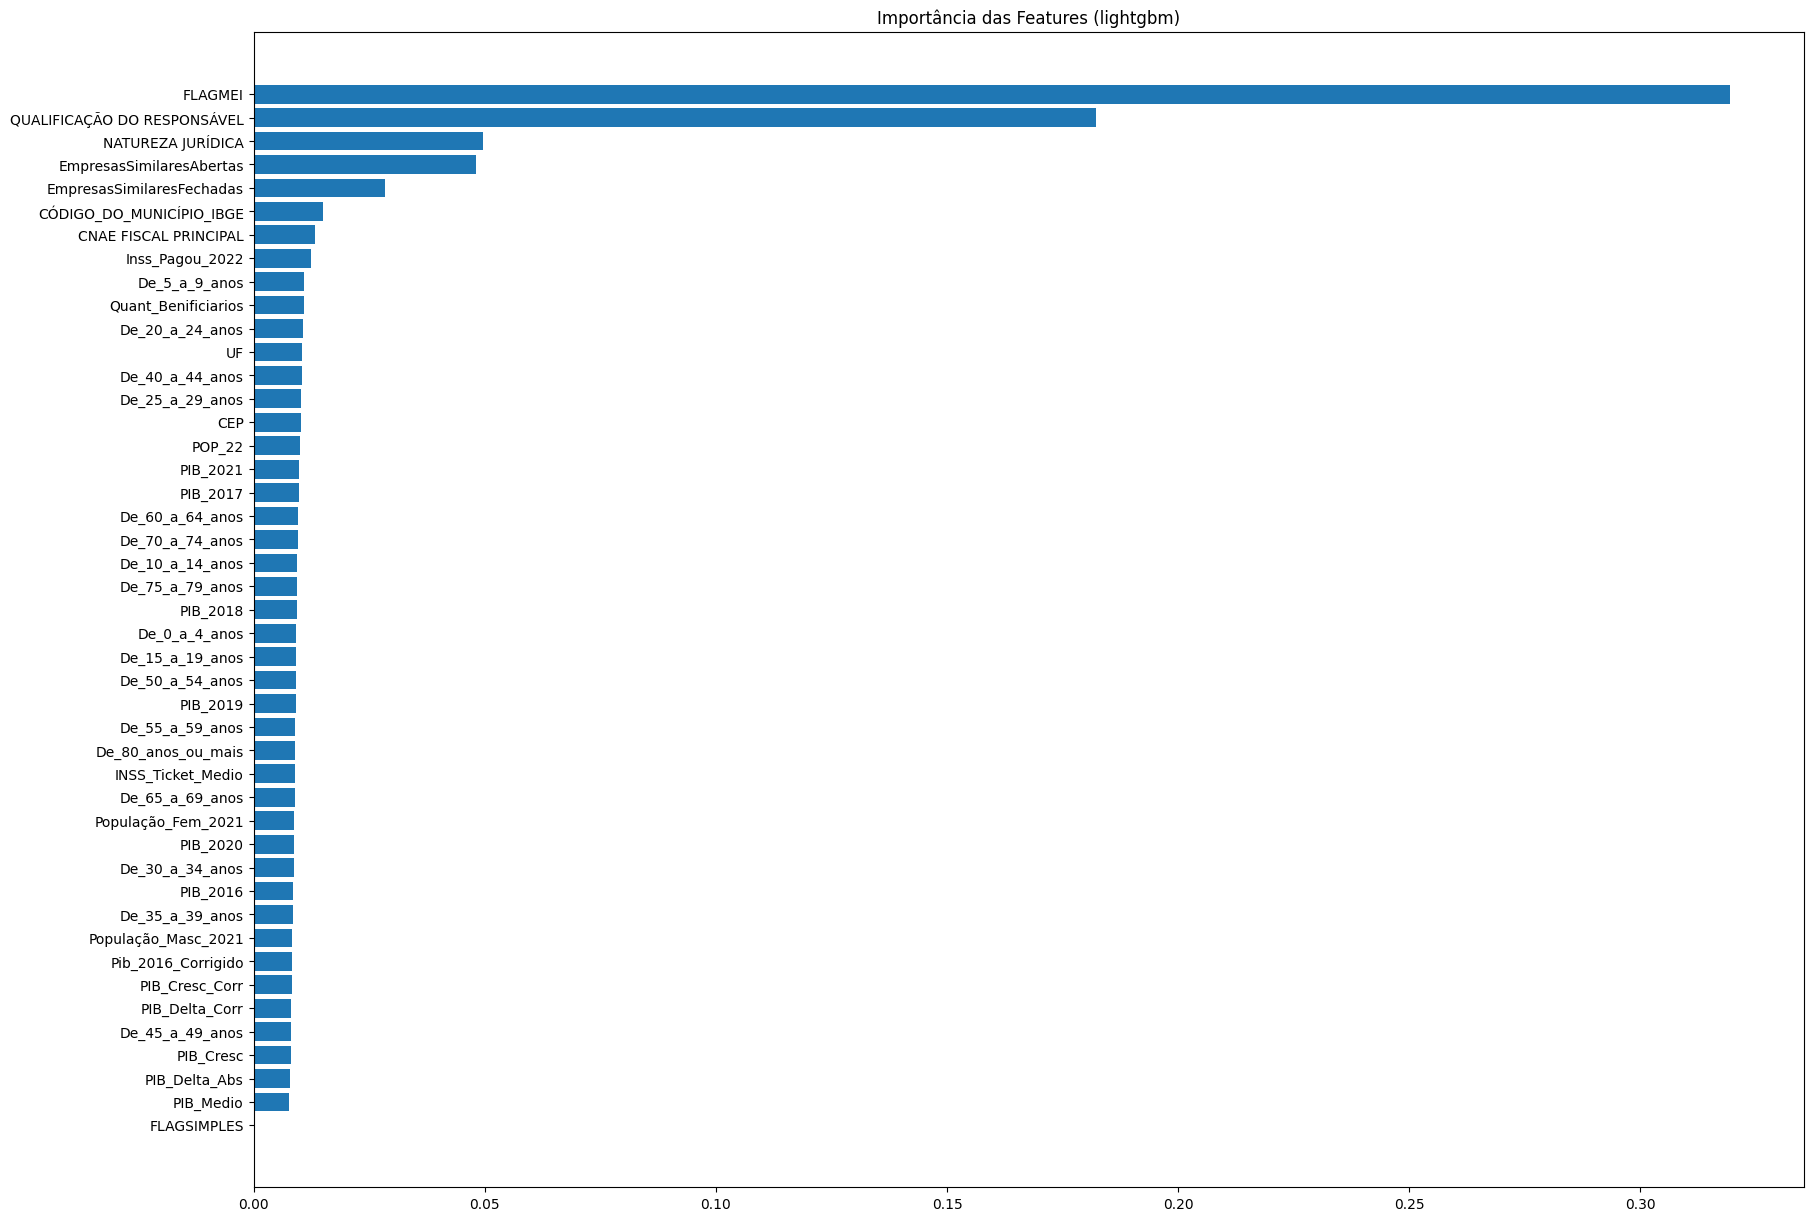

In [52]:
plt.figure(figsize=(20, 15))
plt.barh(feat_importance['Feature'], feat_importance['Importance'])
plt.gca().invert_yaxis()
plt.title('Importância das Features (lightgbm)')
plt.show()
